# GOLD PRICE PREDICTION USING ARIMA

---



---



# Importing File

In [ ]:
# import module
import os

# input data file
current_directory = os.getcwd()
print(f"Current working directory: {current_directory}")
file_path = "/ML Project Data.xlsx"
file_directory = os.path.dirname(file_path)
print(f"Directory of the file: {file_directory}")

Current working directory: /content
Directory of the file: /


# Importing Libraries

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.font_manager as fm
import plotly.graph_objects as go
!pip install plotly==5.15.0
!pip install statsmodels
from statsmodels.tsa.seasonal import seasonal_decompose
import plotly.graph_objects as go
from matplotlib import pyplot as plt
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
from datetime import datetime, timedelta


# Loading Data

In [ ]:
df_data = pd.read_excel('/content/ML Project Data.xlsx')
df_data.head()

,Date,Open,High,Low,Close,Change(Pips),Change(%)
0,2021-07-04,1787.22,1787.73,1785.00,1786.39,-83,-0.05
1,2021-07-05,1786.68,1794.00,1783.80,1791.15,447,0.25
2,2021-07-06,1790.85,1814.89,1789.89,1795.68,483,0.27
3,2021-07-07,1795.28,1809.50,1793.41,1803.22,794,0.44
4,2021-07-08,1803.29,1818.00,1793.90,1803.75,46,0.03


# Data Cleaning and Preprocessing

In [ ]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 622 entries, 0 to 621
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          622 non-null    datetime64[ns]
 1   Open          622 non-null    float64       
 2   High          622 non-null    float64       
 3   Low           622 non-null    float64       
 4   Close         622 non-null    float64       
 5   Change(Pips)  622 non-null    int64         
 6   Change(%)     622 non-null    float64       
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 34.1 KB


In [ ]:
print (df_data.isnull().sum())

Date            0
Open            0
High            0
Low             0
Close           0
Change(Pips)    0
Change(%)       0
dtype: int64


In [ ]:
# >>There are no null values

In [ ]:
df_data.describe()

,Date,Open,High,Low,Close,Change(Pips),Change(%)
count,622,622.000000,622.000000,622.000000,622.000000,622.000000,622.000000
mean,2022-07-04 16:35:29.903536896,1833.470354,1844.208939,1822.538248,1833.592749,12.239550,0.003617
min,2021-07-04 00:00:00,1627.270000,1640.760000,1615.040000,1626.890000,-5559.000000,-3.050000
25%,2022-01-04 06:00:00,1775.080000,1787.085000,1765.435000,1774.957500,-704.000000,-0.380000
50%,2022-07-05 12:00:00,1815.230000,1826.375000,1808.335000,1815.470000,11.500000,0.005000
75%,2023-01-02 18:00:00,1913.792500,1924.717500,1896.670000,1914.700000,749.500000,0.410000
max,2023-07-04 00:00:00,2052.780000,2071.320000,2030.770000,2051.930000,6612.000000,3.330000
std,NaN,94.417731,95.163303,93.223079,94.345885,1480.617616,0.804528


In [ ]:
# Set "Date" column as the index

df_data = df_data.set_index('Date')
df_data.head()


,Open,High,Low,Close,Change(Pips),Change(%)
Date,,,,,,
2021-07-04,1787.22,1787.73,1785.00,1786.39,-83,-0.05
2021-07-05,1786.68,1794.00,1783.80,1791.15,447,0.25
2021-07-06,1790.85,1814.89,1789.89,1795.68,483,0.27
2021-07-07,1795.28,1809.50,1793.41,1803.22,794,0.44
2021-07-08,1803.29,1818.00,1793.90,1803.75,46,0.03


# Visualizations

# 1. Daily Closing Price

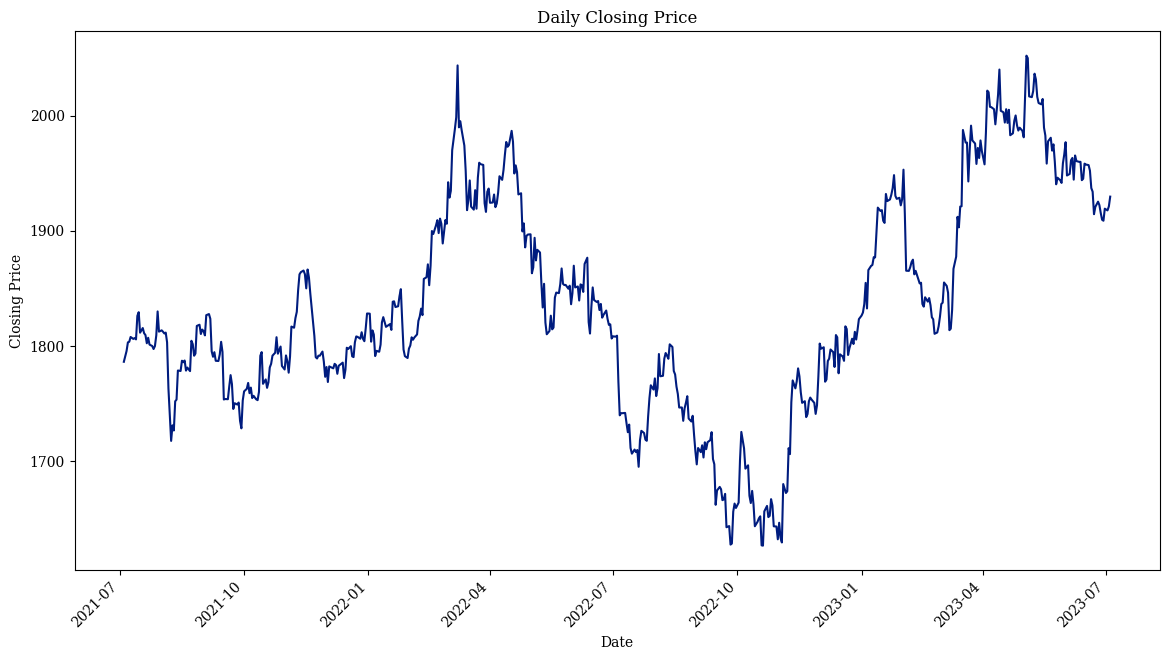

In [ ]:
plt.style.use('seaborn-v0_8-dark-palette')
plt.figure(figsize=(14,7))
plt.plot(df_data['Close'], label='Closing Price')
plt.title('Daily Closing Price', fontname='DejaVu Serif')
plt.xlabel('Date', fontname='DejaVu Serif')
plt.xticks(fontname='DejaVu Serif')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Closing Price', fontname='DejaVu Serif')
plt.yticks(fontname='DejaVu Serif')
plt.show()

# 2. First Difference of Close Price

In [ ]:
first_difference = df_data['Close'].diff()[1:]
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_data.index[1:], y=first_difference, mode='lines', name='First Difference'))
fig.update_layout(
    title='First Difference of Close Price',
    title_font=dict(family='DejaVu Serif', size=20),
    xaxis_title='Date',
    yaxis_title='Price',
    font=dict(size=15),
    xaxis=dict(
        tickangle=45,
        tickfont=dict(family='DejaVu Serif', size=15)
    ),
    yaxis=dict(
        tickfont=dict(family='DejaVu Serif', size=15)
    )

)
fig.show()

# 3. Seasonal Decomposition

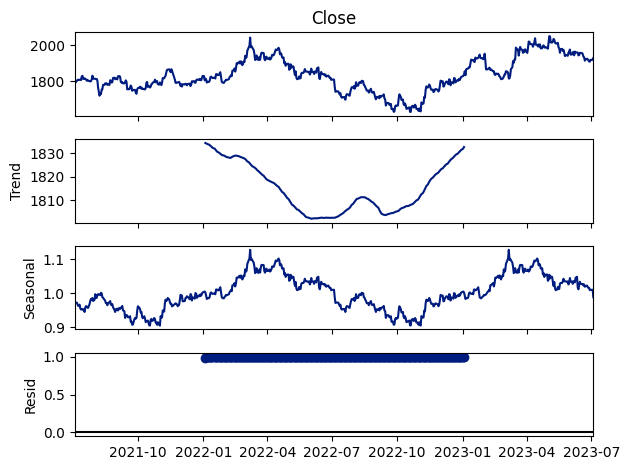

In [ ]:
# Calculate the period dynamically based on the number of observations
period = int(len(df_data) / 2)  # Ensure at least 2 cycles

# Adjust the period to a sensible value if it's too large or small
# For example, cap it at 365 for daily data
period = min(period, 365)

decomposition = seasonal_decompose(df_data['Close'], model='multiplicative', period=period)
decomposition.plot()
plt.show()

# ARIMA Model for Forecasting

# 1. Splitting the Data

In [ ]:
#splitting the data
num_split=int(df_data['Close'].shape[0]*0.8)
train_set=df_data['Close'].iloc[:num_split]
test_set=df_data['Close'].iloc[num_split:]
test_set

,Close
Date,
2023-02-08,1874.97
2023-02-09,1862.23
2023-02-10,1865.28
2023-02-13,1854.34
2023-02-14,1854.94
...,...
2023-06-29,1908.76
2023-06-30,1919.20
2023-07-02,1917.70


# 2. Selecting the Most Optimal Model for ARIMA

In [ ]:
!pip install pmdarima
import pmdarima as pm
model = pm.auto_arima(train_set, start_p=0, start_q=0, start_order=0, max_p=10 ,max_q=10, max_order=10, test='adf', stepwise=False, trace=True, seasonal=False)

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4068.747, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4070.747, Time=0.22 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4067.737, Time=0.24 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4067.218, Time=0.43 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=4068.410, Time=0.48 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=4070.107, Time=1.26 sec
 ARIMA(0,1,6)(0,0,0)[0] intercept   : AIC=4071.488, Time=3.35 sec
 ARIMA(0,1,7)(0,0,0)[0] intercept   : AIC=4070.820, Time=1.12 sec
 ARIMA(0,1,8)(0,0,0)[0] intercept   : AIC=4072.308, Time=1.13 sec
 ARIMA(0,1,9)(0,0,0)[0] intercept   : AIC=4071.500, Time=0.91 sec
 ARIMA(0,1,10)(0,0,0)[0] intercept   : AIC=4072.349, Time=1.40 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4070.747, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4070.269, Time=0.42 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4068.340, Time=0.30 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4068.263, Time=0.42 sec
 ARIMA(1,

In [ ]:
# Getting the best order of the model
best_order = model.order

# Getting the best model summary
best_model = model.arima_res_
best_model_summary = best_model.summary()

print('Best order:', best_order)
print('Best model summary:\n', best_model_summary)

Best order: (0, 1, 3)
Best model summary:
                                SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  497
Model:               SARIMAX(0, 1, 3)   Log Likelihood               -2028.609
Date:                Thu, 21 Nov 2024   AIC                           4067.218
Time:                        01:57:46   BIC                           4088.251
Sample:                             0   HQIC                          4075.474
                                - 497                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1739      0.651      0.267      0.789      -1.102       1.450
ma.L1          0.0040      0.040      0.099      0.921      -0.074       0.082
ma.L2    

# 3. Rolling Forecast Prediction

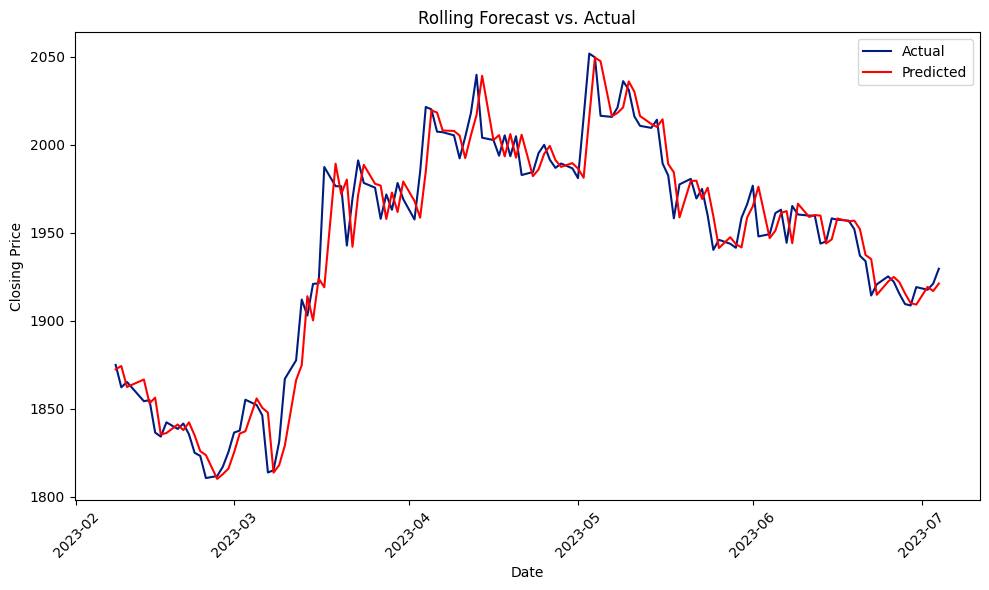

In [ ]:
rolling_pred = test_set.copy()  # Create a copy to store predictions
for split_num in test_set.index:
    # Create training set up to the day before the prediction date:
    train_set = df_data['Close'][:split_num-timedelta(days=1)]

    # Fit the ARIMA model:
    model = ARIMA(train_set, order=best_order)
    model_fit = model.fit()

    # Make a one-step-ahead forecast:
    pred = model_fit.forecast()

    # Store the prediction:
    rolling_pred[split_num] = pred.iloc[0]  # Access the first element of the prediction Series


# Plotting the results
plt.figure(figsize=(10, 6))  # Set figure size
plt.plot(test_set.index, test_set.values, label='Actual')  # Plot actual values
plt.plot(test_set.index, rolling_pred.values, label='Predicted', color='red')  # Plot predicted values
plt.title('Rolling Forecast vs. Actual')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout for better spacing
plt.show()

# 4. Calalculating and Plotting the Residuals

Text(0, 0.5, 'Error')

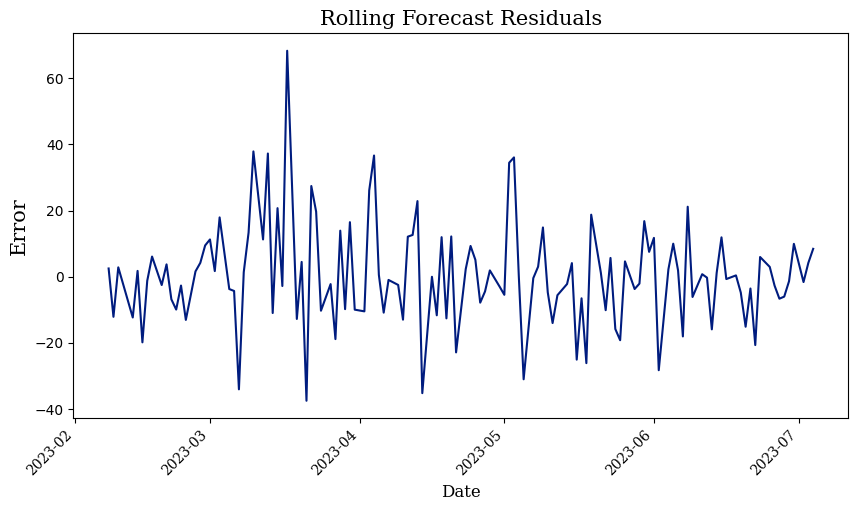

In [ ]:
rolling_residuals = test_set - rolling_pred
plt.figure(figsize=(10,5))
plt.plot(rolling_residuals)
plt.title('Rolling Forecast Residuals', fontname='DejaVu Serif', fontsize=15)
plt.xlabel('Date', fontname='DejaVu Serif', fontsize=12)
plt.xticks(rotation=45, ha='right', fontname='DejaVu Serif', fontsize=10)
plt.ylabel('Error', fontname='DejaVu Serif', fontsize=15)

# Trading Strategy Development

# 1. Simple Moving Average Strategy

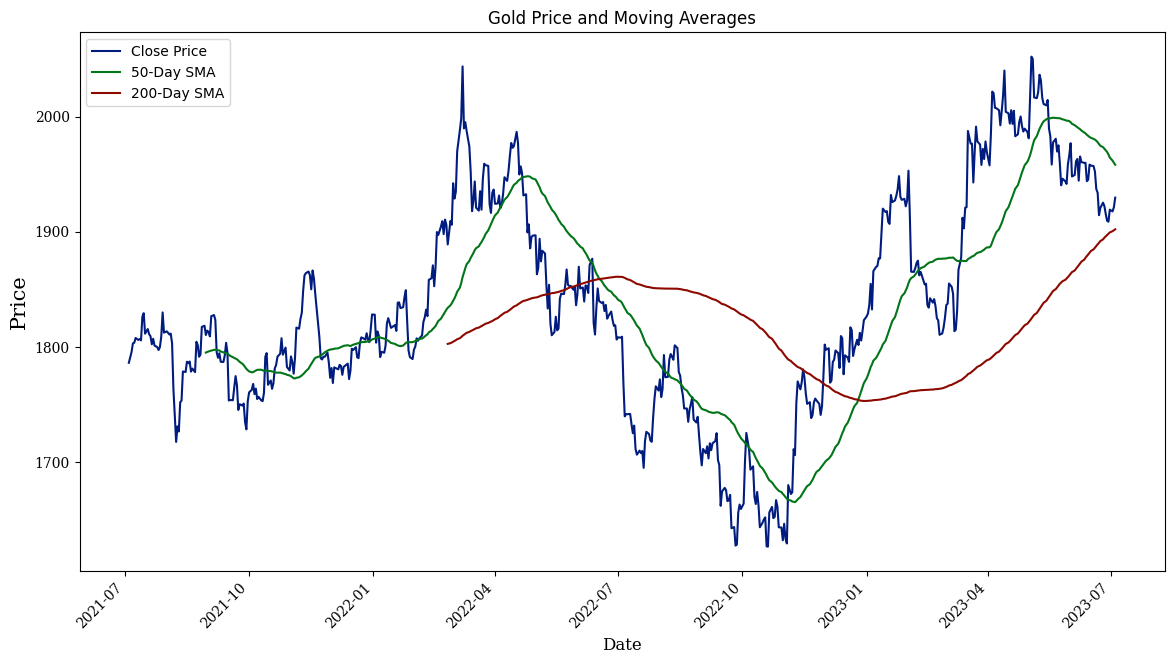

MSE: 247.84393787535282
MAPE: 0.005768216076678497


In [ ]:
df_data['SMA_50'] = df_data['Close'].rolling(window=50).mean()
df_data['SMA_200'] = df_data['Close'].rolling(window=200).mean()
plt.figure(figsize=(14, 7))
plt.plot(df_data['Close'], label='Close Price')
plt.plot(df_data['SMA_50'], label='50-Day SMA')
plt.plot(df_data['SMA_200'], label='200-Day SMA')
plt.title('Gold Price and Moving Averages')
plt.xlabel('Date', fontname='DejaVu Serif', fontsize=12)
plt.xticks(rotation=45, ha='right', fontname='DejaVu Serif', fontsize=10)
plt.ylabel('Price', fontname='DejaVu Serif', fontsize=15)
plt.yticks(fontname='DejaVu Serif', fontsize=10)
plt.ylabel('Price')
plt.legend()
plt.show()

#Evaluating the model
mse = mean_squared_error(test_set.values, rolling_pred.values)
print('MSE:', mse)
mape = mean_absolute_percentage_error(test_set.values, rolling_pred.values)
print('MAPE:', mape)

# Gold Closing Prices and S&P 500 Correlation

In [ ]:
import pandas as pd
import os

# Specify the full file paths
gold_file_path = "ML Project Data.xlsx"
sp500_file_path = "ML Project Data 2.xlsx"

# Load the Excel files from the desktop
gold_df = pd.read_excel(gold_file_path)
sp500_df = pd.read_excel(sp500_file_path)

# Assuming both dataframes have a 'Date' column in the same format
# Convert 'Date' columns to datetime format for both datasets
gold_df['Date'] = pd.to_datetime(gold_df['Date'])
sp500_df['Date'] = pd.to_datetime(sp500_df['Date'])

# Merge both datasets on the 'Date' column, keeping only common dates (inner join)
merged_df = pd.merge(gold_df, sp500_df, on='Date', how='inner')

# Now you have a merged dataframe with only the common dates between the two datasets
# You can continue with your analysis from here
print(merged_df.head())

        Date   Open_x   High_x    Low_x    Close  Change(Pips)  Change(%)  \
0 2021-07-06  1790.85  1814.89  1789.89  1795.68           483       0.27   
1 2021-07-07  1795.28  1809.50  1793.41  1803.22           794       0.44   
2 2021-07-08  1803.29  1818.00  1793.90  1803.75            46       0.03   
3 2021-07-09  1803.87  1812.38  1796.53  1807.89           402       0.22   
4 2021-07-12  1806.32  1809.43  1791.84  1806.95            63       0.03   

   Close/Last   Open_y   High_y    Low_y  
0     4343.54  4356.46  4356.46  4314.37  
1     4358.13  4351.01  4361.88  4329.79  
2     4320.82  4321.07  4330.88  4289.37  
3     4369.55  4329.38  4371.60  4329.38  
4     4384.63  4372.41  4386.68  4364.03  


In [ ]:
# Print the columns of the merged dataframe to see the actual column names
print(merged_df.columns)

# Calculate the correlation between the closing prices
# Replace 'Close.y' with the actual column name from the printed list
correlation = merged_df['Close'].corr(merged_df['Close/Last'])  # Update column name here

print(f"Correlation between Gold and S&P 500 closing prices: {correlation}")

Index(['Date', 'Open_x', 'High_x', 'Low_x', 'Close', 'Change(Pips)',
       'Change(%)', 'Close/Last', 'Open_y', 'High_y', 'Low_y'],
      dtype='object')
Correlation between Gold and S&P 500 closing prices: 0.21399822795418733


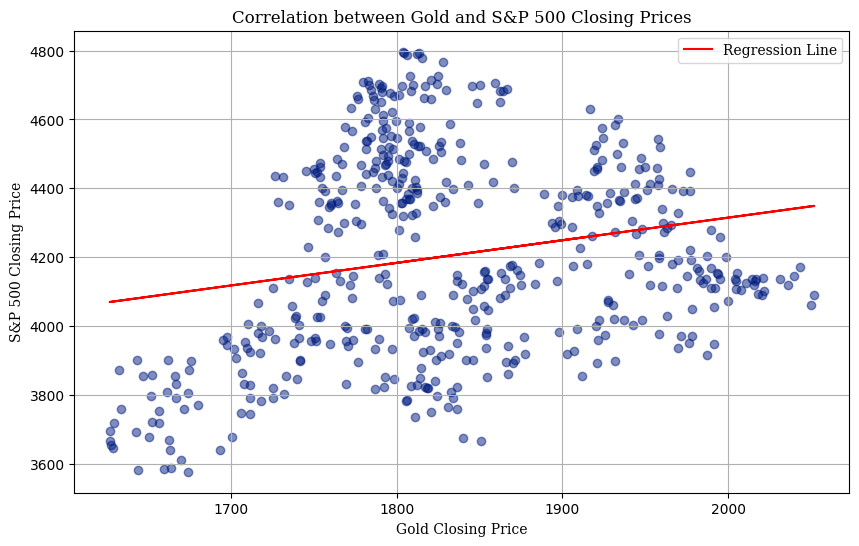

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(merged_df['Close'], merged_df['Close/Last'], alpha=0.5)
plt.title('Correlation between Gold and S&P 500 Closing Prices', fontname='DejaVu Serif')
plt.xlabel('Gold Closing Price', fontname='DejaVu Serif')
plt.ylabel('S&P 500 Closing Price', fontname='DejaVu Serif')
plt.grid(True)
x = merged_df['Close']
y = merged_df['Close/Last']
coefficients = np.polyfit(x, y, 1)
polynomial = np.poly1d(coefficients)
plt.plot(x, polynomial(x), color='red', label='Regression Line')
plt.legend(prop={'family': 'DejaVu Serif'})
plt.show()